In [14]:
import numpy as np
import qiskit.pulse as pulse
import qiskit.circuit as circuit
from qiskit.providers.tergite import Tergite
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
from qiskit.providers.jobstatus import JobStatus
import tqcsf.file

In [2]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend("Nov7")
backend.set_options(shots=1500)
print(f"Loaded Tergite backend {backend.name}")

Loaded Tergite backend Nov7


In [7]:
def schedule(*, index: int, ro_freq_Hz: float, ro_amp_V: float):
    param_sched = pulse.ScheduleBlock()

    # delay 40 µs
    param_sched += pulse.Delay(40 * 1000, channel=backend.measure_channel(index))
    param_sched += pulse.Delay(40 * 1000, channel=backend.acquire_channel(index))

    # readout 3µs
    param_sched += pulse.SetFrequency(ro_freq_Hz, backend.measure_channel(index))
    param_sched += pulse.Play(
        pulse.Constant(3000, ro_amp_V), channel=backend.measure_channel(index)
    )

    # time of flight 300ns
    param_sched += pulse.Delay(300, backend.acquire_channel(index))

    # integration window 2.5 µs
    param_sched += pulse.Acquire(
        duration=2500,
        channel=backend.acquire_channel(index),
        mem_slot=backend.memory_slot(index),
    )

    return param_sched

In [8]:
index = 0
approx_fr_Hz = 6741583902.617835
span_Hz = 5e6
sweepdef_Hz = np.arange(approx_fr_Hz - span_Hz / 2, approx_fr_Hz + span_Hz / 2, 0.1e6)

In [9]:
sweep = [schedule(index=index, ro_freq_Hz=fr, ro_amp_V=0.00125) for fr in sweepdef_Hz]
print("Sweep length:", len(sweep))

Sweep length: 50


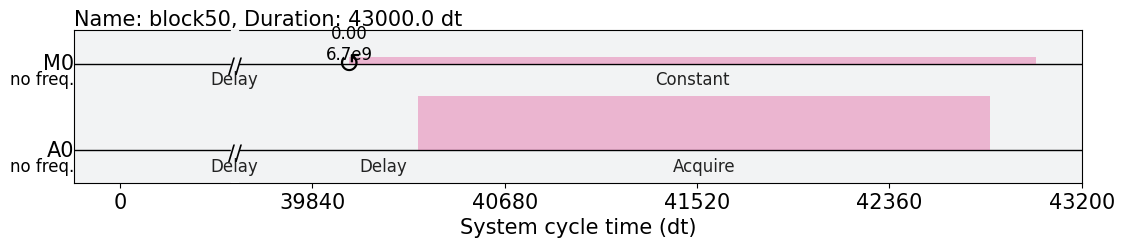

In [10]:
sweep[0].draw(style=IQXDebugging())

In [12]:
sweep_header = {
    "sweep": {
        "serial_order": ("x0",),
        "parameters": {
            "x0": {
                "long_name": "Frequency of readout pulse",
                "unit": "Hz",
                "slots": {index: sweepdef_Hz},
            }
        },
    }
}
job = backend.run(sweep, meas_level=1, qobj_header=sweep_header)

Tergite: Job has been successfully submitted


In [15]:
# wait for job to complete
while job.status() != JobStatus.DONE:
    time.sleep(1)

In [16]:
# fetch storage file from BCC
sf = tqcsf.file.StorageFile(job.logfile, mode="r")
vars(sf)

{'mode': 'r',
 'file': <HDF5 file "05d369b6-6fdd-427f-90c3-590fc8bde72a.hdf5" (mode r)>,
 'tuid': '20221027-125001-229-48a3c0',
 'meas_return': <MeasRet.AVERAGED: 1>,
 'meas_level': <MeasLvl.INTEGRATED: 1>,
 'meas_return_cols': 1,
 'job_id': '05d369b6-6fdd-427f-90c3-590fc8bde72a',
 'local': False,
 'header': <HDF5 group "/header" (1 members)>,
 'experiments': <HDF5 group "/experiments" (50 members)>}

In [17]:
# parse to xarray dataset, only possible for sweeps
ds = sf.as_xarray()
ds

20221027-125001-229-48a3c0:   0%|          | 0/50 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:       (x0/slot~0: 50)
Coordinates:
  * x0/slot~0     (x0/slot~0) float64 6.739e+09 6.739e+09 ... 6.744e+09
Data variables:
    slot~0/acq~0  (x0/slot~0) complex128 (0.008529298811268524+0.006537602344...
Attributes:
    job_id:            05d369b6-6fdd-427f-90c3-590fc8bde72a
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20221027-125001-229-48a3c0

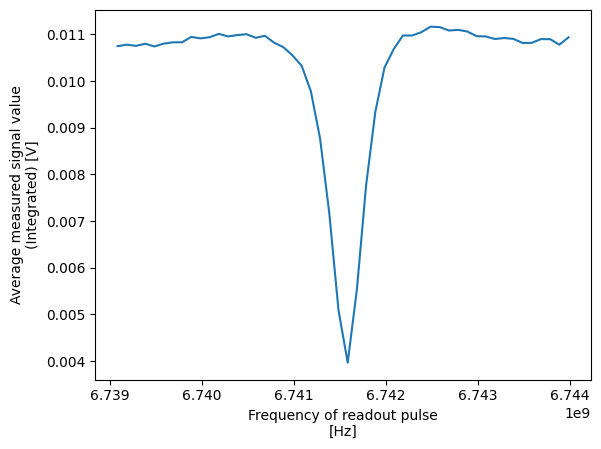

In [18]:
np.abs(ds[f"slot~{index}/acq~0"]).plot()